In [1]:
%load_ext autoreload
%autoreload 2
import sys
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
import sasc.viz
import joblib
import dvu
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import analyze_helper, viz
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
# flatmaps_per_question = __import__('06_flatmaps_per_question')
import viz

Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### load gemv average flatmaps

In [2]:
gemv_avgs_pilot = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot.pkl'))
gemv_avgs_pilot5 = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot5.pkl'))
gemv_avg_flatmaps = gemv_avgs_pilot | gemv_avgs_pilot5

In [3]:
# matches
qa_list = [
    # approx matches
    'Is time mentioned in the input?',
    'Does the input contain a measurement?',
    # 'Does the input contain a number?',
    'Does the sentence mention a specific location?',
    # 'Does the sentence describe a relationship between people?',
    # 'Does the sentence describe a relationship between people?',
    'Does the text describe a mode of communication?',
    # 'Does the sentence contain a negation?',
]
gemv_list = [
    # approx matches
    ('time', 212),
    ('measurements', 171),
    # ('measurements', 171),
    # ('moments',	337),
    # ('locations', 122),
    ('locations', 368),
    # ('emotion', 179),
    # ('emotional expression', 398),
    ('communication', 299),
    # ('negativity', 248)
]


qa_list += [
    'Is the sentence abstract rather than concrete?',
    'Does the sentence contain a cultural reference?',
    'Does the sentence include dialogue?',
    'Is the input related to a specific industry or profession?',
    'Does the sentence contain a negation?',
    'Does the input contain a number?',
    "Does the sentence express the narrator's opinion or judgment about an event or character?",
    'Does the sentence describe a personal or social interaction that leads to a change or revelation?',
    'Does the sentence describe a personal reflection or thought?',
    'Does the sentence involve an expression of personal values or beliefs?',
    'Does the sentence describe a physical action?',
    'Does the input involve planning or organizing?',
    'Does the sentence contain a proper noun?',
    'Does the sentence describe a relationship between people?',
    'Does the sentence describe a sensory experience?',
    'Does the sentence involve the mention of a specific object or item?',
    'Does the sentence include technical or specialized terminology?',
]

gemv_list += [
    ('abstract descriptions', 'qa'),
    ('cultural references', 'qa'),
    ('dialogue', 'qa'),
    ('industry or profession', 'qa'),
    ('negations', 'qa'),
    ('numbers', 'qa'),
    ('opinions or judgments', 'qa'),
    ('personal or interactions interactions', 'qa'),
    ('personal reflections or thoughts', 'qa'),
    ('personal values or beliefs', 'qa'),
    ('physical actions', 'qa'),
    ('planning or organizing', 'qa'),
    ('proper nouns', 'qa'),
    ('relationships between people', 'qa'),
    ('sensory experiences', 'qa'),
    ('specific objects or items', 'qa'),
    ('technical or specialized terminology', 'qa')
]

df_pairs = pd.DataFrame({
    'qa_weight': qa_list,
    'gemv_avg_resp': gemv_list,
})

In [6]:
subject = 'UTS02'
# df_qa_dict = joblib.load(f'df_qa_dict_{subject.replace("UT", "")}.pkl')

/home/chansingh/fmri/qa_results/gemv/corrs_full_35


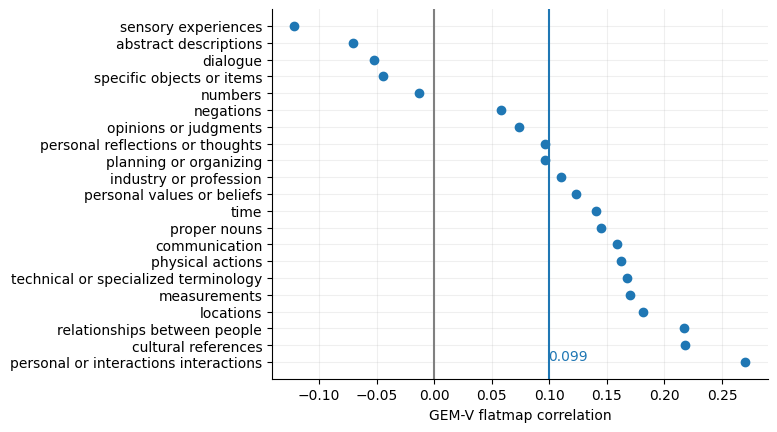

In [5]:
# for setting in df_qa_dict.keys():
# setting = 'avg_individual'
# setting = 'shapley_35'
# setting = 'individual'
setting = 'full_35'
# df_qa_weights = df_qa_dict[setting]
df_qa_weights = joblib.load(
    join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))

if isinstance(df_qa_weights, pd.DataFrame):
    df_pairs = df_pairs[df_pairs['qa_weight'].isin(df_qa_weights.index)]
    flatmaps_qa = df_qa_weights.loc[df_pairs['qa_weight'].values]['weights'].values
else:
    flatmaps_qa = [df_qa_weights[bd]
                   for bd in df_pairs['qa_weight'].values]
flatmaps_gemv = [gemv_avg_flatmaps[bd]
                 for bd in df_pairs['gemv_avg_resp'].values]

titles_gt = df_pairs['gemv_avg_resp'].apply(lambda x: x[0]).astype(str)
corrs = viz._calc_corrs(
    flatmaps_qa,
    flatmaps_gemv,
    titles_qa=[analyze_helper.abbrev_question(
        q) for q in df_pairs['qa_weight'].astype(str)],
    titles_gt=titles_gt,
)
corrs_df = pd.DataFrame({'corrs': np.diag(
    corrs.values), 'questions': corrs.columns}).sort_values('corrs', ascending=False)
corrs_df.to_pickle(join(repo_dir, 'qa_results', 'gemv',
                        setting + '_corrs_df.pkl'))

viz.corr_bars(
    corrs,
    out_dir_save=join(repo_dir, 'qa_results', 'gemv',
                      'corrs_' + setting),
    xlab='GEM-V',
)
plt.show()

# # save flatmaps
# for i in tqdm(range(len(flatmaps_qa))):
#     sasc.viz.quickshow(
#         flatmaps_qa[i],
#         subject=subject,
#         fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
#                         setting, f'{titles_gt[i]}.png')
#     )

#     sasc.viz.quickshow(
#         flatmaps_gemv[i],
#         subject=subject,
#         fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
#                         'gemv', f'{titles_gt[i]}.png')
#     )

# Look at merged flatmaps

In [17]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results',
                               'gemv', setting + '_corrs_df.pkl'))

In [18]:
img_dir1 = join(repo_dir, 'qa_results', 'gemv',
                subject, 'gemv')
img_dir2 = join(repo_dir, 'qa_results', 'gemv',
                subject, setting)

# read images and combine them with their filenames on a single plot
# fnames = os.listdir(img_dir1)
# fnames = [f for f in fnames if f.endswith('.png')]
# only keep the ones that are in both directories
# fnames = [f for f in fnames if f in os.listdir(img_dir2)]


# corrs = corrs.sort_values('corrs', ascending=False)
fnames = [v + '.png' for v in corrs_df['questions'].values]

n = len(fnames)
C = 4
R = int(np.ceil(n / C))

fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].axis('off')
for i, fname in enumerate(fnames):
    img1 = plt.imread(join(img_dir1, fname))
    img2 = plt.imread(join(img_dir2, fname))
    axs[i].imshow(np.concatenate([img1, img2], axis=1))
    axs[i].set_title(
        f'{fname[:-4]} ({corrs_df["corrs"].values[i]:0.3f})', fontsize=8)

# add text in bottom right of figure
fig.text(0.99, 0.01, f'{subject}\nGEMV on left, QA on right',
         ha='right', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig(join(repo_dir, 'qa_results', 'gemv',
            subject, f'flatmaps_{setting}_{subject}.png'), dpi=300)
plt.close()